# neuron

In [1]:
from cnsproject.network.neural_populations import AELIFPopulation
n = AELIFPopulation((1,), dt=1)

In [5]:
from cnsproject.utils import generate_function
I = generate_function(250, shape=(1,),
           shift={0: 75, 150: 50},
           noise=10,
           population_noise=1)

In [6]:
from cnsproject.monitors.monitors import Monitor
m = Monitor(n, ['s','w','u'], time=250)
m.simulate(n.forward, inputs={'direct_input': I})

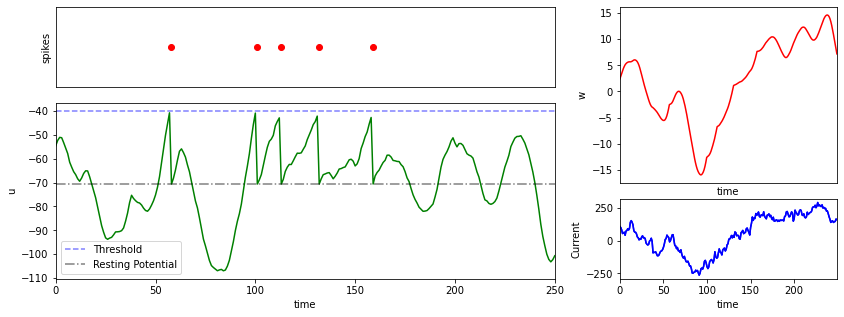

In [7]:
import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter

plt.figure(figsize=(14,5))
p = Plotter([
    ['s','s','w'],
    ['u','u','w'],
    ['u','u','i'],
], wspace=0.3, monitor=m)
p.neuron_spike('s', x_vis=False)
p.neuron_voltage('u')
p.current_dynamic('i', I=I)
p.adaptation_current_dynamic('w', x_vis=False)
p.show()

# neural_populations

In [8]:
from cnsproject.network.neural_populations import LIFPopulation
n = LIFPopulation((4,50), dt=1)

In [9]:
from cnsproject.utils import generate_function
I = generate_function(250, shape=(4,50),
           shift={0: 75, 150: 50},
           noise=10,
           population_noise=5)

In [10]:
from cnsproject.monitors.monitors import Monitor
m = Monitor(n, ['s'], time=250)
m.simulate(n.forward, inputs={'direct_input': I})

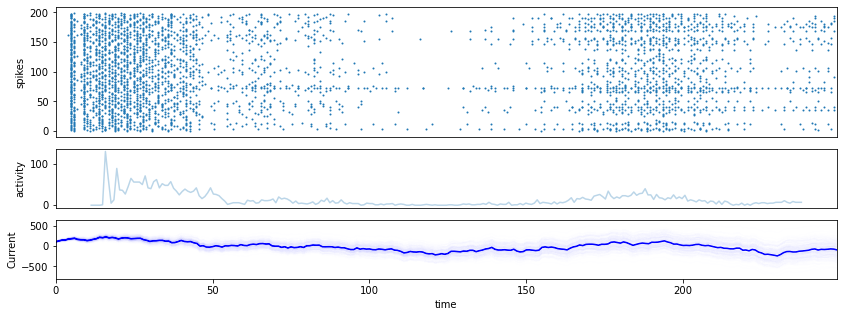

In [11]:
import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter

plt.figure(figsize=(14,5))
p = Plotter([
    ['s'],
    ['s'],
    ['a'],
    ['i'],
], wspace=0.3, monitor=m)
p.population_activity_raster('s', x_vis=False)
p.population_activity('a', x_vis=False)
p.current_dynamic('i', I=I)
p.show()

# axon_set

In [1]:
import torch
import warnings
warnings.filterwarnings("ignore")

In [2]:
from cnsproject.network.neural_populations import LIFPopulation
n = LIFPopulation((2,), dt=1.)

In [3]:
from cnsproject.utils import generate_function
I = generate_function(2500, shape=(1,),
           shift={0: 50, 150: 50},
           noise=.1,
           population_noise=1)
I = torch.abs(I)

In [4]:
from cnsproject.network.axon_sets import SimpleAxonSet
a0 = SimpleAxonSet(
        population=(2,),
        terminal=(3,),
        delay=torch.tensor([0,20])
    )
n.add_axon_set(a0, 'a0')

In [5]:
from cnsproject.network.axon_sets import SimpleAxonSet
a1 = SimpleAxonSet(
        population=(2,),
        terminal=(2,),
        delay=torch.tensor([[0,20],[0,20]])
    )
n.add_axon_set(a1, 'a1')

In [6]:
from cnsproject.network.axon_sets import SRFAxonSet
a2 = SRFAxonSet(
        population=(2,),
        terminal=(2,), #terminal shape is 1 per each axon
        tau=torch.tensor([[7.,11.],[7.,11.]]),
        max_spikes_at_the_same_time=3,
    )
n.add_axon_set(a2, 'a2')

In [7]:
from cnsproject.network.axon_sets import SRFAxonSet
a3 = SRFAxonSet(
        population=(2,),
        terminal=(3,), #terminal shape is 1 per each axon
        delay=torch.tensor([0,20]),
        tau=9.,
        max_spikes_at_the_same_time=3,
    )
n.add_axon_set(a3, 'a3')

In [8]:
from cnsproject.network.axon_sets import SRFAxonSet
a4 = SRFAxonSet(
        population=(2,),
        terminal=(2,), #terminal shape is 1 per each axon
        delay=torch.tensor([0,10]),
        tau=torch.tensor([[7.,11.],[7.,11.]]),
        max_spikes_at_the_same_time=3,
    )
n.add_axon_set(a4, 'a4')

In [9]:
from cnsproject.monitors.monitors import Monitor
a0.reset()
a1.reset()
a2.reset()
a3.reset()
a4.reset()
n.reset()
ma0 = Monitor(a0, ['e'])
ma1 = Monitor(a1, ['e'])
ma2 = Monitor(a2, ['e'])
ma3 = Monitor(a3, ['e'])
ma4 = Monitor(a4, ['e'])
m = Monitor(n, ['s','u'], time=250)
m.simulate(n.forward, inputs={'direct_input': I}, attendance=[ma0,ma1,ma2,ma3,ma4])

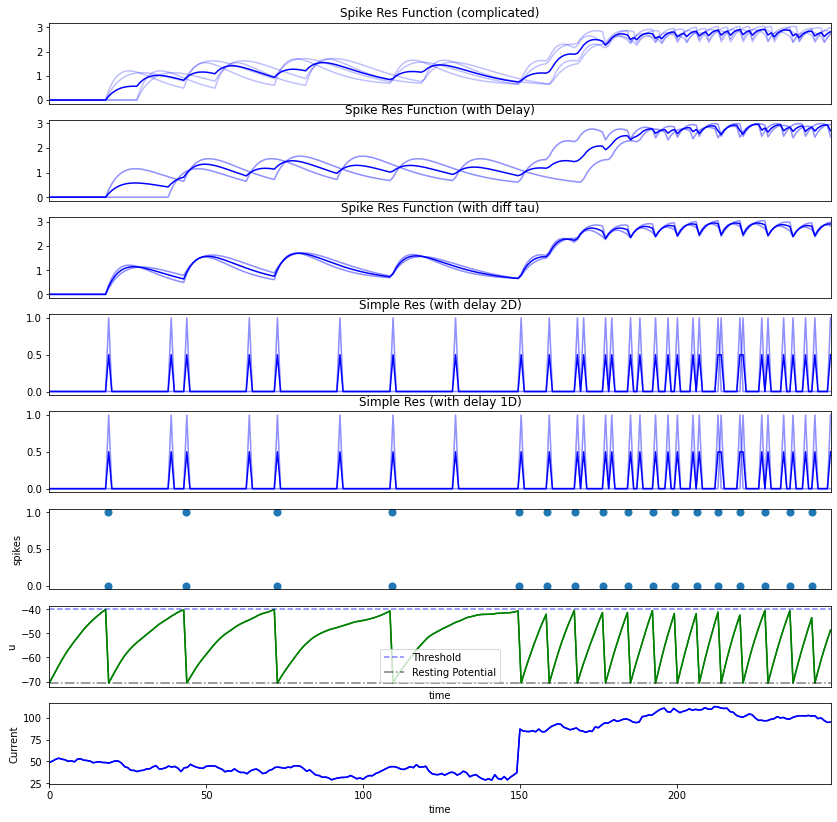

In [10]:
import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter

plt.figure(figsize=(14,14))
p = Plotter([
    ['a4'],
    ['a3'],
    ['a2'],
    ['a1'],
    ['a0'],
    ['s'],
    ['u'],
    ['i'],
], wspace=0.3, monitor=m)
p.current_dynamic('i', I=I[:250])
p.neuron_voltage('u', x_vis=False)
p.population_activity_raster('s', x_vis=False, s=50)
p.population_plot('a0', y='e', x_vis=False, title="Simple Res (with delay 1D)", monitor=ma0, x_lim='fit')
p.population_plot('a1', y='e', x_vis=False, title="Simple Res (with delay 2D)", monitor=ma1, x_lim='fit')
p.population_plot('a2', y='e', x_vis=False, title="Spike Res Function (with diff tau)", monitor=ma2, x_lim='fit')
p.population_plot('a3', y='e', x_vis=False, title="Spike Res Function (with Delay)", monitor=ma3, x_lim='fit')
p.population_plot('a4', y='e', x_vis=False, title="Spike Res Function (complicated)", monitor=ma4, x_lim='fit')
p.show()

Also works well in multi dims and multo terminals.

# dendrite_set

In [11]:
import torch
import warnings
warnings.filterwarnings("ignore")

In [12]:
from cnsproject.utils import generate_function
I = generate_function(250, shape=(10,),
           shift={0: 50, 150: 50},
           noise=.1,
           population_noise=1)
I = torch.abs(I)

In [13]:
from cnsproject.network.neural_populations import LIFPopulation
n1 = LIFPopulation((10,), dt=1.)
n2 = LIFPopulation((1,), dt=1.)

In [14]:
from cnsproject.network.axon_sets import SimpleAxonSet,SRFAxonSet
a1 = SimpleAxonSet(
    population=(10,),
    terminal=(2,2)
)
n1.add_axon_set(a1, 'a1')
a2 = SRFAxonSet(
        population=(10,),
        scale=2.,
        max_spikes_at_the_same_time=3
    )
n1.add_axon_set(a2, 'a2')

In [15]:
from cnsproject.network.dendrite_sets import SimpleDendriteSet
from cnsproject.network.weight_initializations import norm_initialization,uniform_initialization

d1 = SimpleDendriteSet(
    terminal=(10,2,2),
    population=(1,),
    w=norm_initialization((10,2,2), (1,), w_mean=.5, w_std=.1),
)
n2.add_dendrite_sets(d1, 'd1')

w = torch.zeros(10,1)
w[4:6,0] = 5
d2 = SimpleDendriteSet(
    terminal=(10,),
    population=(1,),
    wmax=5.,
    w=w, # or w=uniform_initialization((10,), (1,), w_range=(0,5))
)
n2.add_dendrite_sets(d2, 'd2')

In [16]:
from cnsproject.monitors.monitors import Monitor
a1.reset()
a2.reset()
n1.reset()
n2.reset()
d1.reset()
d2.reset()
mn1 = Monitor(n1, ['s'], time=250)
ma1 = Monitor(a1, ['e'])
ma2 = Monitor(a2, ['e'])
md1 = Monitor(d1, ['I'])
md2 = Monitor(d2, ['I'])
mn2 = Monitor(n2, ['u'])

In [17]:
def run(direct_input): # instead of network (for testing step by step)
    d1.forward(a1.neurotransmitters())
    d2.forward(a2.neurotransmitters())
    n1.forward(direct_input=direct_input)
    n2.forward()
    
mn1.simulate(run, inputs={'direct_input': I},
             attendance=[mn2,ma1,ma2,md1,md2])

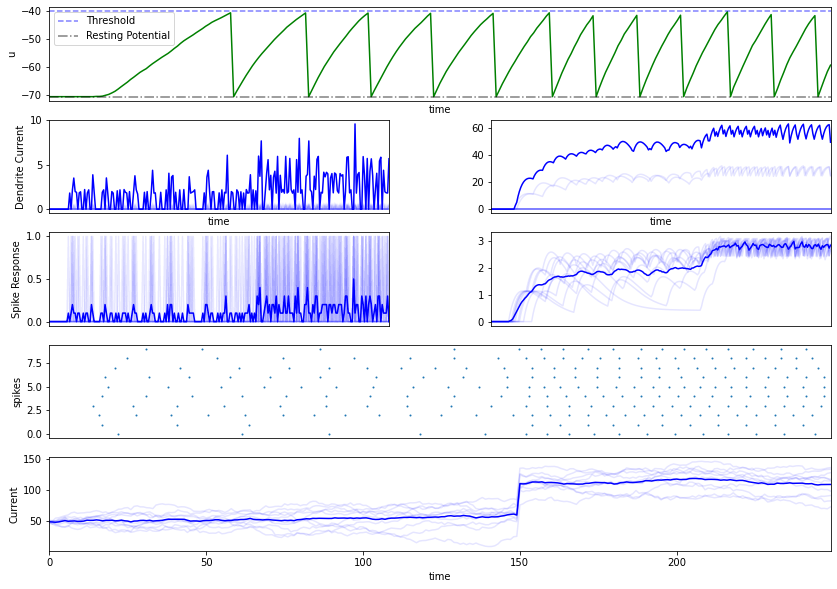

In [18]:
import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter

plt.figure(figsize=(14,10))
p = Plotter([
    ['u','u'],
    ['d1','d2'],
    ['a1','a2'],
    ['s','s'],
    ['i','i'],
], wspace=0.3)
p.current_dynamic('i', I=I)
p.population_activity_raster('s', x_vis=False, monitor=mn1)
p.spike_response_function('a1', x_vis=False, monitor=ma1)
p.spike_response_function('a2', x_vis=False, y_label='', monitor=ma2)
p.dendrite_current('d1', x_vis=False, y_label="Dendrite Current", monitor=md1)
p.dendrite_current('d2', x_vis=False, y_label='', monitor=md2)
p.neuron_voltage('u', x_vis=False, monitor=mn2)
p.show()

Dendrite response to nan values is right

In [19]:
from cnsproject.monitors.monitors import Monitor
a1.reset()
a2.reset()
n1.reset()
n2.reset()
d1.reset()
d2.reset()

z = 0
def run(direct_input): # instead of network (for testing step by step)
    global z
    d1.forward(a1.neurotransmitters())
    z += 1
    if z > 100:
        temp = a2.neurotransmitters()
        temp[:temp.shape[0]//2] = float("nan")
        d2.forward(temp)
    else:
        d2.forward(a2.neurotransmitters())
    n1.forward(direct_input=direct_input)
    n2.forward()
    
mn1.simulate(run, inputs={'direct_input': I},
             attendance=[mn2,ma1,ma2,md1,md2])

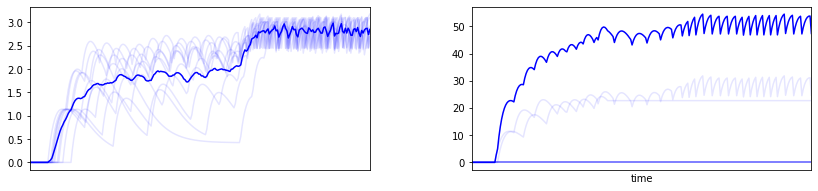

In [20]:
import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter

plt.figure(figsize=(14,3))
p = Plotter([
    ['a2','d2'],
], wspace=0.3)
p.spike_response_function('a2', x_vis=False, y_label='', monitor=ma2)
p.dendrite_current('d2', x_vis=False, y_label='', monitor=md2)
p.show()

Also works well in multi dims and multo terminals.

In [21]:
from cnsproject.network.neural_populations import LIFPopulation
n1 = LIFPopulation((10,), dt=1.)
n2 = LIFPopulation((10,10), dt=1.)

from cnsproject.network.axon_sets import SimpleAxonSet
a1 = SimpleAxonSet(
    population=(10,),
    terminal=(2,),
    scale=5.,
)
n1.add_axon_set(a1, 'a1')

from cnsproject.network.dendrite_sets import SimpleDendriteSet
from cnsproject.network.weight_initializations import norm_initialization
d1 = SimpleDendriteSet(
    terminal=(10,2),
    population=(10,10),
    wmax=10.,
    w=norm_initialization((10,2), (10,10), w_mean=5., w_std=1.),
)
n2.add_dendrite_sets(d1, 'd1')

from cnsproject.monitors.monitors import Monitor
n1.reset()
a1.reset()
d1.reset()
n2.reset()
mn1 = Monitor(n1, ['s'], time=250)
ma1 = Monitor(a1, ['e'])
md1 = Monitor(d1, ['I'])
mn2 = Monitor(n2, ['s'])

In [22]:
from cnsproject.utils import generate_function
I = generate_function(250, shape=(10,),
           shift={0: 50, 150: 50},
           noise=.1,
           population_noise=1)
I = torch.abs(I)

def run(direct_input): # instead of network (for testing step by step)
    d1.forward(a1.neurotransmitters())
    n1.forward(direct_input=direct_input)
    n2.forward()
    
mn1.simulate(run, inputs={'direct_input': I},
             attendance=[mn2,ma1,md1])

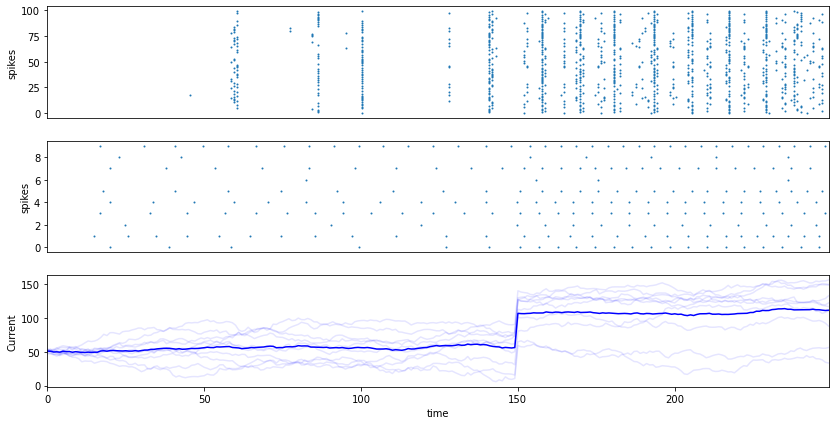

In [23]:
import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter

plt.figure(figsize=(14,7))
p = Plotter([
    ['s2'],
    ['s1'],
    ['i'],
], wspace=0.3)
p.current_dynamic('i', I=I)
p.population_activity_raster('s1', y='s', x_vis=False, monitor=mn1)
p.population_activity_raster('s2', y='s', x_vis=False, monitor=mn2)
p.show()

# synapse_set

In [24]:
import torch
import warnings
warnings.filterwarnings("ignore")

from cnsproject.network.neural_populations import LIFPopulation
n1 = LIFPopulation((10,), dt=1.)
n2 = LIFPopulation((10,10), dt=1.)

from cnsproject.network.axon_sets import SimpleAxonSet
a1 = SimpleAxonSet(
    population=(10,),
    terminal=(2,),
    scale=5.,
)
n1.add_axon_set(a1, 'a1')

from cnsproject.network.dendrite_sets import SimpleDendriteSet
from cnsproject.network.weight_initializations import norm_initialization
d1 = SimpleDendriteSet(
    terminal=(10,2),
    population=(10,10),
    wmax=10.,
    w=norm_initialization((10,2), (10,10), w_mean=5., w_std=1.),
)
n2.add_dendrite_sets(d1, 'd1')

from cnsproject.monitors.monitors import Monitor
n1.reset()
a1.reset()
d1.reset()
n2.reset()
mn1 = Monitor(n1, ['s'], time=250)
ma1 = Monitor(a1, ['e'])
md1 = Monitor(d1, ['I'])
mn2 = Monitor(n2, ['s'])

from cnsproject.utils import generate_function
import torch
I = generate_function(250, shape=(10,),
           shift={0: 50, 150: 50},
           noise=.1,
           population_noise=1)
I = torch.abs(I)

In [25]:
from cnsproject.network.synapse_sets import SimpleSynapseSet
from cnsproject.network.connectivity_patterns import rfnopp_connectivity

s1 = SimpleSynapseSet(
    axon_set = a1,
    dendrite_set = d1,
    dt = 1.,
    connectivity = rfnopp_connectivity((10,2),(10,10), c_rate=.8)
)
s1.reset()

In [26]:
def run(direct_input): # instead of network (for testing step by step)
    s1.forward()
    n1.forward(direct_input=direct_input)
    n2.forward()
    
mn1.simulate(run, inputs={'direct_input': I},
             attendance=[mn2,ma1,md1])

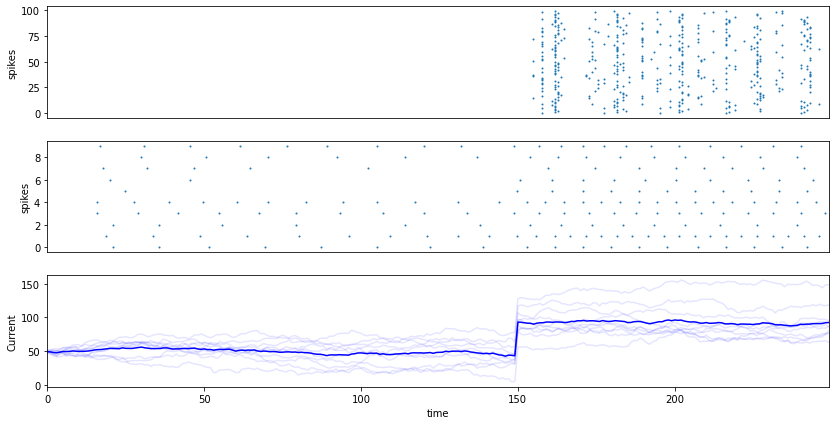

In [27]:
import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter

plt.figure(figsize=(14,7))
p = Plotter([
    ['s2'],
    ['s1'],
    ['i'],
], wspace=0.3)
p.current_dynamic('i', I=I)
p.population_activity_raster('s1', y='s', x_vis=False, monitor=mn1)
p.population_activity_raster('s2', y='s', x_vis=False, monitor=mn2)
p.show()

Connection can be not fully described!

In [37]:
import torch
import warnings
warnings.filterwarnings("ignore")

from cnsproject.network.neural_populations import LIFPopulation
n1 = LIFPopulation((2,), dt=1.)
n2 = LIFPopulation((3,3), dt=1.)

from cnsproject.network.axon_sets import SRFAxonSet
a1 = SRFAxonSet(
    population=(2,),
    terminal=(2,),
    scale=25.,
    delay=(torch.rand(2,2)*20),
    tau=(5+torch.rand(2,2)*10),
)
n1.add_axon_set(a1, 'a1')

from cnsproject.network.dendrite_sets import SimpleDendriteSet
from cnsproject.network.weight_initializations import norm_initialization
d1 = SimpleDendriteSet(
    terminal=(1,3),
    population=(3,3),
    wmax=10.,
    w=norm_initialization((1,3), (3,3), w_mean=5., w_std=1.),
)
n2.add_dendrite_sets(d1, 'd1')

from cnsproject.monitors.monitors import Monitor
n1.reset()
a1.reset()
d1.reset()
n2.reset()
mn1 = Monitor(n1, ['s'], time=250)
ma1 = Monitor(a1, ['e'])
md1 = Monitor(d1, ['I'])
mn2 = Monitor(n2, ['s'])

from cnsproject.utils import generate_function
import torch
I = generate_function(250, shape=(2,),
           shift={0: 50, 150: 50},
           noise=.1,
           population_noise=1)
I = torch.abs(I)

from cnsproject.network.synapse_sets import FilterSynapseSet
passage = torch.tensor([
    [[
        [True, False, True],
        [False, True, True],
        [True, True, False],
    ],[
        [True, True, False],
        [True, True, True],
        [True, False, True],
    ]]
])

s1 = FilterSynapseSet(
    axon_set = a1,
    dendrite_set = d1,
    dt = 1.,
    passage = passage,
    axon_passage = [[1],True],
    dendrite_terminal_passage = [True,[0,2]]
)

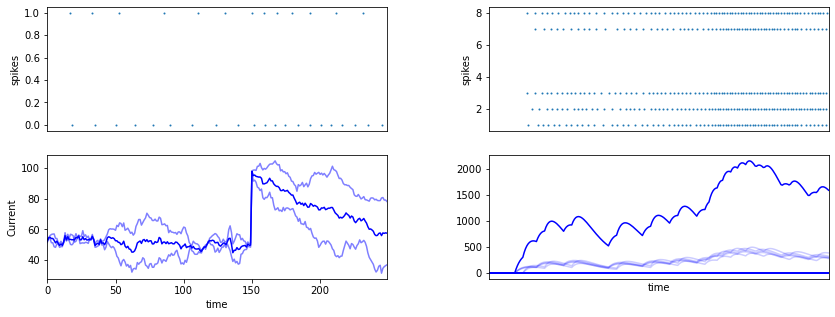

In [38]:
def run(direct_input): # instead of network (for testing step by step)
    s1.forward()
    n1.forward(direct_input=direct_input)
    n2.forward()
    
mn1.simulate(run, inputs={'direct_input': I},
             attendance=[mn2,ma1,md1])

import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter

plt.figure(figsize=(14,5))
p = Plotter([
    ['s1','s2'],
    ['i','d2'],
], wspace=0.3)
p.current_dynamic('i', I=I)
p.dendrite_current('d2', x_vis=False, y_label='', monitor=md1, population_alpha=.2)
p.population_activity_raster('s1', y='s', x_vis=False, monitor=mn1)
p.population_activity_raster('s2', y='s', x_vis=False, monitor=mn2)
p.show()

# network

In [63]:
import warnings
warnings.filterwarnings("ignore")
import torch
import matplotlib.pyplot as plt
from cnsproject.network.network import Network
from cnsproject.network.neural_populations import LIFPopulation
from cnsproject.network.axon_sets import SimpleAxonSet
from cnsproject.network.dendrite_sets import SimpleDendriteSet
from cnsproject.network.synapse_sets import SimpleSynapseSet
from cnsproject.network.weight_initializations import norm_initialization
from cnsproject.network.connectivity_patterns import rfnopp_connectivity,in_rfnopp_connectivity
from cnsproject.monitors.monitors import Monitor
from cnsproject.monitors.plotter import Plotter
from cnsproject.utils import generate_function

In [75]:
n1 = LIFPopulation((4 ,50))
n2 = LIFPopulation((4 ,50))
n3 = LIFPopulation((12,2 ))
a1_1 = SimpleAxonSet(population=n1.shape, scale=2)
a2_2 = SimpleAxonSet(population=n2.shape, scale=2)
a1_3 = SimpleAxonSet(population=n1.shape, scale=20)
a3_1 = SimpleAxonSet(population=n3.shape, scale=20, is_excitatory=False)
a2_3 = SimpleAxonSet(population=n2.shape, scale=20)
a3_2 = SimpleAxonSet(population=n3.shape, scale=20, is_excitatory=False)
n1.add_axon_set(a1_1, 'a1_1')
n1.add_axon_set(a1_3, 'a1_3')
n2.add_axon_set(a2_2, 'a2_2')
n2.add_axon_set(a2_3, 'a2_3')
n3.add_axon_set(a3_1, 'a3_1')
n3.add_axon_set(a3_2, 'a3_2')
d1_1 = SimpleDendriteSet(terminal=n1.shape, population=n1.shape, w=norm_initialization(n1.shape,n1.shape))
d2_2 = SimpleDendriteSet(terminal=n2.shape, population=n2.shape, w=norm_initialization(n2.shape,n2.shape))
d1_3 = SimpleDendriteSet(terminal=n1.shape, population=n3.shape, w=norm_initialization(n1.shape,n3.shape))
d3_1 = SimpleDendriteSet(terminal=n3.shape, population=n1.shape, w=norm_initialization(n3.shape,n1.shape))
d2_3 = SimpleDendriteSet(terminal=n2.shape, population=n3.shape, w=norm_initialization(n2.shape,n3.shape))
d3_2 = SimpleDendriteSet(terminal=n3.shape, population=n2.shape, w=norm_initialization(n3.shape,n2.shape))
n1.add_dendrite_sets(d1_1, 'd1_1')
n1.add_dendrite_sets(d3_1, 'd3_1')
n2.add_dendrite_sets(d2_2, 'd2_2')
n2.add_dendrite_sets(d3_2, 'd3_2')
n3.add_dendrite_sets(d1_3, 'd1_3')
n3.add_dendrite_sets(d2_3, 'd2_3')
s1_1 = SimpleSynapseSet(axon_set=a1_1, dendrite_set=d1_1, connectivity=in_rfnopp_connectivity(n1.shape, c_rate=.2))
s2_2 = SimpleSynapseSet(axon_set=a2_2, dendrite_set=d2_2, connectivity=in_rfnopp_connectivity(n2.shape, c_rate=.2))
s1_3 = SimpleSynapseSet(axon_set=a1_3, dendrite_set=d1_3, connectivity=rfnopp_connectivity(n1.shape,n3.shape, c_rate=.8))
s3_1 = SimpleSynapseSet(axon_set=a3_1, dendrite_set=d3_1, connectivity=rfnopp_connectivity(n3.shape,n1.shape, c_rate=.8))
s2_3 = SimpleSynapseSet(axon_set=a2_3, dendrite_set=d2_3, connectivity=rfnopp_connectivity(n2.shape,n3.shape, c_rate=.8))
s3_2 = SimpleSynapseSet(axon_set=a3_2, dendrite_set=d3_2, connectivity=rfnopp_connectivity(n3.shape,n2.shape, c_rate=.8))
net = Network(dt=1.)
net.add_population(n1, 'n1')
net.add_population(n2, 'n2')
net.add_population(n3, 'n3')
net.add_synapse(s1_1, 's1_1')
net.add_synapse(s2_2, 's2_2')
net.add_synapse(s1_3, 's1_3')
net.add_synapse(s3_1, 's3_1')
net.add_synapse(s2_3, 's2_3')
net.add_synapse(s3_2, 's3_2')

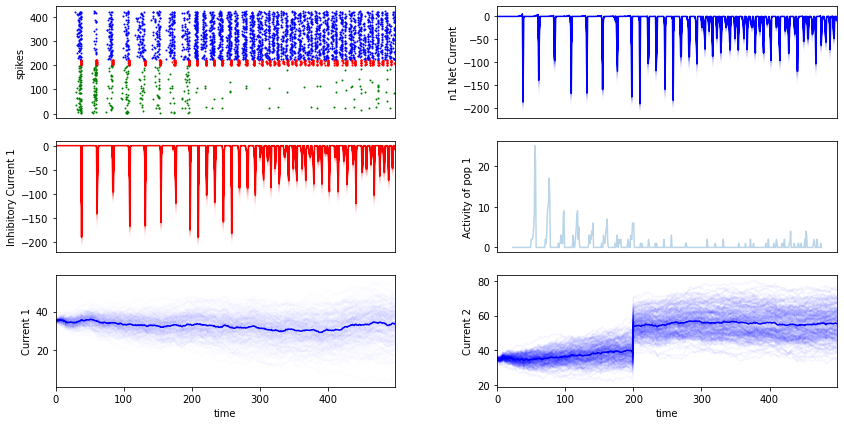

In [77]:
mn1 = Monitor(n1, ['s'])
mn2 = Monitor(n2, ['s'])
mn3 = Monitor(n3, ['s'])
m = Monitor(net, state_calls={
    'i3_1': d3_1.currents,
    'cI': n1.collect_I,
}, time=500)

I1 = torch.abs(generate_function(500, shape=n1.shape, shift={0: 35}, noise=.1, population_noise=.2))
I2 = torch.abs(generate_function(500, shape=n2.shape, shift={0: 35, 200: 15}, noise=.1, population_noise=.2))

net.reset()
m.simulate(net.forward, inputs={'n1_direct_input': I1, 'n2_direct_input': I2},
             attendance=[mn1,mn2,mn3])

plt.figure(figsize=(14,7))
p = Plotter([
    ['s','ci'],
    ['e1','a1'],
    ['i1','i2'],
], wspace=0.3)
p.current_dynamic('i1', I=I1, y_label="Current 1", population_alpha=.01)
p.current_dynamic('i2', I=I2, y_label="Current 2", population_alpha=.04)
p.current_dynamic('e1', y='i3_1', y_label="Inhibitory Current 1", monitor=m, color='r', x_vis=False, x_label='')
p.current_dynamic('ci', y='cI', y_label="n1 Net Current", monitor=m, x_vis=False, x_label='')
p.population_activity('a1', y_label="Activity of pop 1", monitor=mn1, x_vis=False, x_label='')
p.population_activity_raster('s', monitor=mn3, color='r', start=n1.s.numel(), x_vis=False, x_label='')
p.population_activity_raster('s', monitor=mn1, color='g', additive=True)
p.population_activity_raster('s', monitor=mn2, color='b', additive=True, start=n1.s.numel()+n3.s.numel())
p.show()

# encoder

In [1]:
import torch
import warnings
warnings.filterwarnings("ignore")

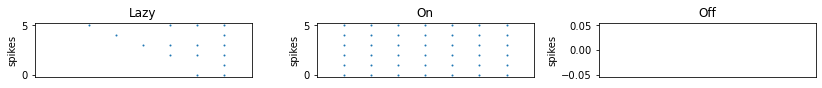

In [2]:
from cnsproject.network.encoders import LazyEncoder,AlwaysOnEncoder,AlwaysOffEncoder

n1 = LazyEncoder((2,3), dt=1)
n2 = AlwaysOnEncoder((2,3), dt=1)
n3 = AlwaysOffEncoder((2,3), dt=1)

from cnsproject.monitors.monitors import Monitor

mn1 = Monitor(n1, ['s'], time=7)
mn2 = Monitor(n2, ['s'])
mn3 = Monitor(n3, ['s'])

def run(direct_input): # instead of network (for testing step by step)
    n1.forward(direct_input=direct_input)
    n2.forward(direct_input=direct_input)
    n3.forward(direct_input=direct_input)
    
I = torch.tensor([
    [[False,False,False],[False,False,False]],
    [[False,False,False],[False,False,True]],
    [[False,False,False],[False,True,False]],
    [[False,False,False],[True,False,False]],
    [[False,False,True],[True,False,True]],
    [[True,False,True],[True,False,True]],
    [[True,True,True],[True,True,True]],
])
    
mn1.simulate(run, inputs={'direct_input': I},
             attendance=[mn2,mn3])

import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter

plt.figure(figsize=(14,1))
p = Plotter([
    ['s1','s2','s3'],
], wspace=0.3)
p.population_activity_raster('s1', y='s', title="Lazy", x_vis=False, monitor=mn1)
p.population_activity_raster('s2', y='s', title="On", x_vis=False, monitor=mn2)
p.population_activity_raster('s3', y='s', title="Off", x_vis=False, monitor=mn3)
p.show()

In [8]:
from cnsproject.network.encoders import *
from cnsproject.monitors.monitors import Monitor
from cnsproject.monitors.plotter import Plotter
import matplotlib.pyplot as plt
import torch
import warnings
warnings.filterwarnings("ignore")
from matplotlib import image
from PIL import Image
import numpy as np

path1 = "image1.jpg"
path2 = "image2.jpeg"
path3 = "image3.jpg"

time = 20
def t2fs_encodding_check(p, im, time=time, postfix='', dt=1, name=''):
    enc = Time2FirstSpikeEncoder(shape=im.shape, max_input=255, time=time, dt=dt)
    enc.encode(torch.from_numpy(im))
    enc_monitor = Monitor(enc, state_variables=["s"], time=time, dt=dt)
    enc_monitor.reset()
    enc_monitor.simulate(enc.forward, {})
    p.population_activity_raster('st'+postfix, monitor=enc_monitor, y_label='spikes', x_label='time',
                                 s=7, alpha=.05)
    p.imshow('it'+postfix, enc.decode(enc_monitor['s'][1:]), cmap='YlGn', interpolation='nearest', title=name)
    return enc_monitor
    
def poisson_encodding_check(p, im, time=time, postfix='', dt=1, name='', max_rate=time):
    enc = PoissonEncoder(shape=im.shape, max_input=255, rate=max_rate/time)
    enc.encode(torch.from_numpy(im))
    enc_monitor = Monitor(enc, state_variables=["s"], time=time, dt=dt)
    enc_monitor.reset()
    enc_monitor.simulate(enc.forward, {})
    data = p.population_activity_raster('sp'+postfix, monitor=enc_monitor, y_label='spikes', x_label='time',
                                 s=7, alpha=.02)
    p.imshow('ip'+postfix, enc.decode(enc_monitor['s'][1:]), cmap='YlGn', interpolation='nearest', title=name)
    return enc_monitor
    
def position_encodding_check(p, im, time=time, postfix='', dt=1, name='', k=10, mean=None, std=None):
    enc = PositionEncoder(shape=im.shape, max_input=255, time=time, dt=dt, k=k, mean=mean, std=std)
    enc.encode(torch.from_numpy(im))
    enc_monitor = Monitor(enc, state_variables=["s",'stage'], time=time, dt=dt)
    enc_monitor.reset()
    enc_monitor.simulate(enc.forward, {})
    data = p.population_activity_raster('sn'+postfix, monitor=enc_monitor, y_label='spikes', x_label='time',
                                 s=7, alpha=.05)
    p.imshow('in'+postfix, enc.decode(enc_monitor['s'][1:]), cmap='YlGn', interpolation='nearest', title=name)
    return enc_monitor
    
def raster_3d(subplot, monitor, shape, reduction=1, s=1, x_r=False, y_r=False, z_r=False, **args):
    d = monitor['s']
    d = d.reshape(d.shape[0],-1)
    xe,ye = np.where(d)
    ax = plt.subplot(subplot, projection='3d')
    ye = np.array(ye)
    ye = ye//reduction
    xd = (np.array(ye)//shape[0])
    yd = (np.array(ye)%shape[1])
    zd = np.array(xe)
    ax.scatter(xd, yd, zd, s=s, **args)
    axes = ax.axes
    if x_r:
        axes.invert_xaxis()
    if z_r:
        axes.invert_zaxis()
    if y_r:
        axes.invert_yaxis()
    ax.set_zlabel("time")

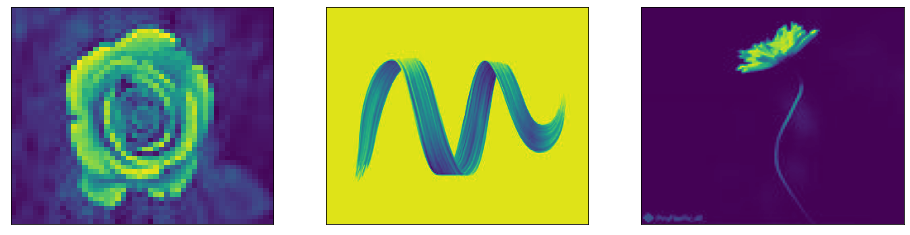

In [9]:
plt.figure(figsize=(16,4))
p = Plotter([
    ['im1','im2', 'im3'],
])
im1 = np.array(Image.open(path1).convert('L'))
gr_im1= Image.fromarray(im1)
p.imshow('im1', gr_im1)

im2 = np.array(Image.open(path2).convert('L'))
gr_im2= Image.fromarray(im2)
p.imshow('im2', gr_im2)

im3 = np.array(Image.open(path3).convert('L'))
gr_im3= Image.fromarray(im3)
p.imshow('im3', gr_im3)

plt.show()

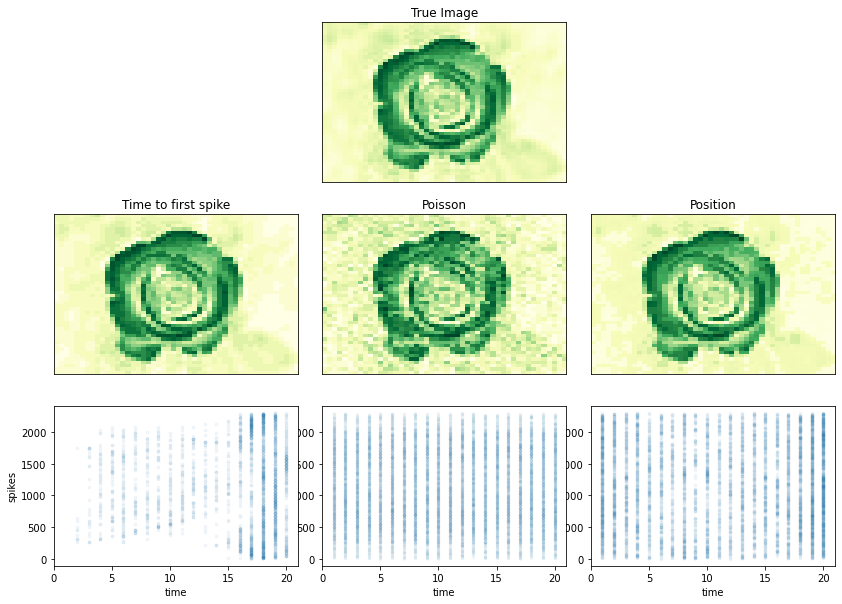

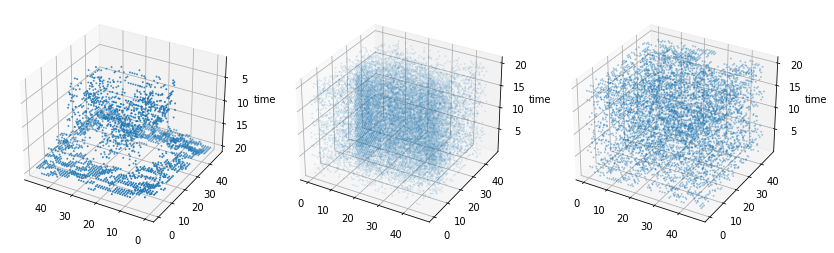

In [10]:
plt.figure(figsize=(14,10))
p = Plotter([
    [None, 'i',None],
    ['it','ip','in'],
    ['st','sp','sn'],
], wspace=0.1, hspace=0.2)

p.imshow('i', im1, "True Image", cmap='YlGn', interpolation='nearest')
d1 = t2fs_encodding_check(p,im1,name='Time to first spike')
d2 = poisson_encodding_check(p,im1,name='Poisson')
d3 = position_encodding_check(p,im1,name='Position')
p.show()

plt.figure(figsize=(14,5))
raster_3d('131', d1, im1.shape, y_r=True, z_r=True)
raster_3d('132', d2, im1.shape, alpha=.1)
raster_3d('133', d3, im1.shape, reduction=10, alpha=.3)
plt.show()

# Learning

In [213]:
class a:
    def __init__(self):
        self.c = 2
        
class b:
    def __init__(self, b=a()):
        self.d = b
        
e = b()
e.d.c += 2
f = b()
f.d.c

4

# Wrapper

In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import matplotlib.pyplot as plt
from cnsproject.network.network import Network
from cnsproject.network.neural_populations import LIFPopulation
from cnsproject.network.axon_sets import SimpleAxonSet
from cnsproject.network.dendrite_sets import SimpleDendriteSet
from cnsproject.network.synapse_sets import SimpleSynapseSet
from cnsproject.network.weight_initializations import norm_initialization
from cnsproject.network.connectivity_patterns import rfnopp_connectivity,in_rfnopp_connectivity
from cnsproject.monitors.monitors import Monitor
from cnsproject.monitors.plotter import Plotter
from cnsproject.utils import generate_function

In [136]:
class Container:
    def __init__(self, dictionary):
        self.__dict__ = dictionary

In [141]:
import re
import numpy as np

class NetworkBuilder:
    def __init__(self):
        self.constructors = {}
        self.constructors["P"] = LIFPopulation
        self.constructors["A"] = lambda p,s: SimpleAxonSet(population=p, scale=s)
        self.constructors["Ainh"] = lambda p,s: SimpleAxonSet(population=p, scale=s, is_excitatory=False)
        self.constructors["S"] = lambda a,d,cr: SimpleSynapseSet(axon_set=a, dendrite_set=d, \
                                                     connectivity=rfnopp_connectivity(\
                                                                      a.shape,d.population_shape,c_rate=cr))
        self.constructors["Sself"] = lambda a,d,cr: SimpleSynapseSet(axon_set=a, dendrite_set=d, \
                                                         connectivity=in_rfnopp_connectivity(a.shape,c_rate=cr))
        self.constructors["D"] = lambda t,p: SimpleDendriteSet(terminal=t, population=p, \
                                                  w=norm_initialization(t,p))
        self.constructors["C"] = lambda a,d,s,cr: self.constructors['S'](\
                                                       self.constructors['A'](a.shape,s),
                                                       self.constructors['D'](d.terminal_shape,d.population_shape),
                                                       cr)
        self.constructors["Cself"] = lambda a,d,s,cr: self.constructors['Sself'](\
                                                       self.constructors['A'](a.shape,s),
                                                       self.constructors['D'](d.terminal_shape,d.population_shape),
                                                       cr)
        self.constructors["Cinh"] = lambda a,d,s,cr: self.constructors['S'](\
                                                       self.constructors['Ainh'](a.shape,s),
                                                       self.constructors['D'](d.terminal_shape,d.population_shape),
                                                       cr)
        self.constructors["Cselfinh"] = lambda a,d,s,cr: self.constructors['Sself'](\
                                                       self.constructors['Ainh'](a.shape,s),
                                                       self.constructors['D'](d.terminal_shape,d.population_shape),
                                                       cr)
        self.INTERSECTION = ['+']
        self.HORIZONTAL = ['-']
        self.VERTICAL = ['|']
        self.VERTICAL_WIRE = self.INTERSECTION+self.VERTICAL
        self.HORIZONTAL_WIRE = self.INTERSECTION+self.HORIZONTAL
        self.LEFT = ['<']
        self.RIGHT = ['>']
        self.DOWN = ['v']
        self.UP = ['^']
        self.HORIZONTAL_WAY = self.HORIZONTAL_WIRE+self.LEFT+self.RIGHT
        self.VERTICAL_WAY = self.VERTICAL_WIRE+self.DOWN+self.UP
        self.POPULATION_LEFT = ['[']
        self.POPULATION_RIGHT = [']']
        self.NAME_SYMBOL = ['/']
        
    def build_net_map(self, net_str):
        lines = net_str.split('\n')
        w = max([len(r) for r in lines])
        for i in range(len(lines)):
            lines[i] = ' '+lines[i]+' '*(w-len(lines[i]))+' '
        lines = [' '*(w+2)]+lines+[' '*(w+2)]
        net_map = [list(r) for r in lines]
        self.lines = lines
        self.net_map = np.array(net_map)
        self.region_map = np.full_like(net_map, '').tolist()
        
    def set_region(self,y,x,name):
        if self.region_map[y][x] != '':
            assert self.region_map[y][x]==name, "Tow regions have same pixel!!"
            return
        self.region_map[y][x] = name
        
        here = self.net_map[y,x]
        if here in self.HORIZONTAL_WIRE:
            for i in [-1,+1]:
                there = self.net_map[y,x+i]
                if there in self.HORIZONTAL_WAY:
                    self.set_region(y,x+i,name)
                elif there in self.VERTICAL and here in self.HORIZONTAL:
                    self.set_region(y,x+2*i,name)
                    
        if here in self.VERTICAL_WIRE:
            for i in [-1,+1]:
                there = self.net_map[y+i,x]
                if there in self.VERTICAL_WAY:
                    self.set_region(y+i,x,name)
                elif self.net_map[y+i,x] in self.HORIZONTAL and here in self.VERTICAL:
                    self.set_region(y+2*i,x,name)
                    
        return True
    
    def build_object(self, definition, extra_inputs=[]):
        if definition=='':
            return None
        constructor = definition.split('(')[0]
        inputs = re.search(r'\((.*)\)', definition).group(1)
        inputs = re.split(",(?=(?:[^\(]*\([^\)]*\))*[^\)]*$)", inputs)
        inputs = [eval(i) for i in inputs if i!='']
        return self.constructors[constructor](*extra_inputs, *inputs)
    
    def set_population_region(self, y, x, name):
        for i in [-1,len(re.split("|".join(self.POPULATION_RIGHT), self.lines[y][x:])[0])+1]:
            if self.net_map[y,x+i] in self.HORIZONTAL_WAY:
                self.set_region(y,x+i,name)
    
    def build_populations(self):
        y,x = np.where(np.isin(self.net_map,self.POPULATION_LEFT))
        population_locations = list(zip(y.tolist(),x.tolist()))
        for y,x in population_locations:
            definition = re.split("|".join(self.POPULATION_RIGHT), self.lines[y][x+1:])[0]
            definition,name = re.split("|".join(self.NAME_SYMBOL), definition)
            self.populations[name] = self.build_object(definition)
            self.set_population_region(y,x,name)
    
#     def set_synapses_region(self, y, xrange, name):
#         for xr in range(*xrange):
#             for i in [-1,1]:
#                 if self.net_map[y+i,xr] in self.UP+self.DOWN:
#                     self.set_region(y+i,xr,name)
#                     if self.net_map[y+i,xr] in self.UP+self.DOWN:
                                       
    def build_synapses(self, direction='r'):
        direction = 1 if direction=='r' else -1
        direction_sym = self.RIGHT if direction==1 else self.LEFT
        y,x = np.where(np.isin(self.net_map, direction_sym))
        synapse_locations = list(zip(y.tolist(),x.tolist()))
        for y,x in synapse_locations:
            before = self.net_map[y,x-direction]
            if before not in self.HORIZONTAL_WIRE:
                continue
            presyn = self.region_map[y][x]
            line = self.lines[y][x+1:] if direction==1 else self.lines[y][:x]
            elements = re.split("|".join(direction_sym), line)
            if direction==-1: elements = list(reversed(elements))
            axon_def, synapse_def, dendrite_def, _ = elements
            postsyn = self.region_map[y][x+direction*(len(axon_def)+1+len(synapse_def)+1+len(dendrite_def)+1)]
            name = presyn+'_'+postsyn
            presyn = self.populations[presyn]
            postsyn = self.populations[postsyn]
            axon = self.build_object(axon_def, [presyn.shape])
            if axon is None: axon = Container({
                'shape': presyn.shape,
                'population_shape': presyn.shape,
                'terminal_shape': ()
            })
            dendrite = self.build_object(dendrite_def, [axon.shape, postsyn.shape])
            if dendrite is None: dendrite = Container({
                'shape': (*axon.shape, *postsyn.shape),
                'terminal_shape': axon.shape,
                'population_shape': postsyn.shape,
            })
            synapse = self.build_object(synapse_def, [axon, dendrite])
            self.synapses[name] = synapse
            presyn.add_axon_set(synapse.axon_set, name)
            postsyn.add_dendrite_sets(synapse.dendrite_set, name)
#             self.set_synapses_region(y, (x+direction*(len(axon_def)+2),
#                             x+direction*(len(axon_def)+1+len(synapse_def)+1),
#                             direction), name)
                                
    def build_net(self, **args):
        self.net = Network(**args)
        for k,v in self.populations.items():
            self.net.add_population(v, k)
        for k,v in self.synapses.items():
            self.net.add_synapse(v, k)
    
    def build(self, net_str, dt=1., **args):
        self.populations = {}
        self.synapses = {}
        self.build_net_map(net_str)
        self.build_populations()
        self.build_synapses('r')
        self.build_synapses('l')
        self.build_net(dt=dt, **args)
        return self.net

In [148]:
net_string = """
+>>Cself(2,.2)>>+    $L(.1)$
+[P((4,50))/Ex1]+-+>>C(20,.8)>>---+
                  +<<Cinh(20,.8)<<+
                                  +-[P((12,2))/Inh]
                  +<<Cinh(20,.8)<<+
+[P((4,50))/Ex2]+-+>>C(20,.8)>>---+
+>>Cself(2,.2)>>+    $L(.1)$
"""
net_builder = NetworkBuilder()
net = net_builder.build(net_string)
net

Network(
  (Ex1): LIFPopulation()
  (Inh): LIFPopulation()
  (Ex2): LIFPopulation()
  (Ex1_Ex1): SimpleSynapseSet(
    (axon_set): SimpleAxonSet()
    (dendrite_set): SimpleDendriteSet()
  )
  (Ex1_Inh): SimpleSynapseSet(
    (axon_set): SimpleAxonSet()
    (dendrite_set): SimpleDendriteSet()
  )
  (Ex2_Inh): SimpleSynapseSet(
    (axon_set): SimpleAxonSet()
    (dendrite_set): SimpleDendriteSet()
  )
  (Ex2_Ex2): SimpleSynapseSet(
    (axon_set): SimpleAxonSet()
    (dendrite_set): SimpleDendriteSet()
  )
  (Inh_Ex1): SimpleSynapseSet(
    (axon_set): SimpleAxonSet()
    (dendrite_set): SimpleDendriteSet()
  )
  (Inh_Ex2): SimpleSynapseSet(
    (axon_set): SimpleAxonSet()
    (dendrite_set): SimpleDendriteSet()
  )
)

In [156]:
0. == True

False

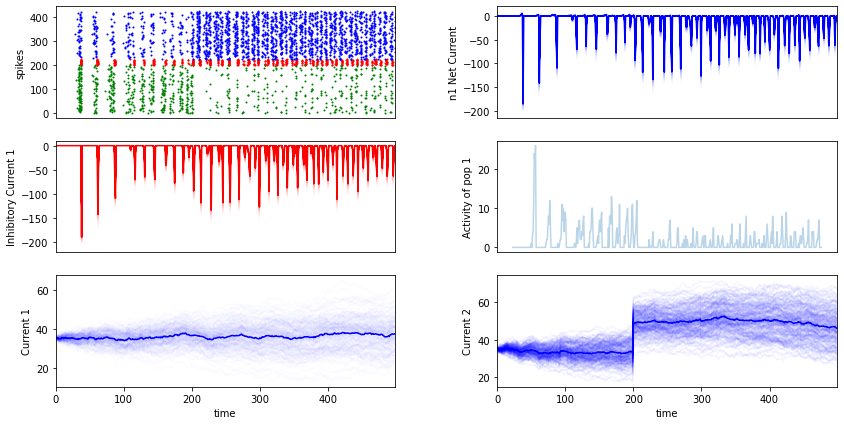

In [149]:
mn1 = Monitor(net.populations['Ex1'], ['s'])
mn2 = Monitor(net.populations['Ex2'], ['s'])
mn3 = Monitor(net.populations['Inh'], ['s'])
m = Monitor(net, state_calls={
    'i3_1': net.synapses['Inh_Ex1'].dendrite_set.currents,
    'cI': net.populations['Ex1'].collect_I,
}, time=500)

I1 = torch.abs(generate_function(500, shape=net.populations['Ex1'].shape, shift={0: 35}, noise=.1, population_noise=.2))
I2 = torch.abs(generate_function(500, shape=net.populations['Ex2'].shape, shift={0: 35, 200: 15}, noise=.1, population_noise=.2))

net.reset()
m.simulate(net.forward, inputs={'Ex1_direct_input': I1, 'Ex2_direct_input': I2},
             attendance=[mn1,mn2,mn3])

plt.figure(figsize=(14,7))
p = Plotter([
    ['s','ci'],
    ['e1','a1'],
    ['i1','i2'],
], wspace=0.3)
p.current_dynamic('i1', I=I1, y_label="Current 1", population_alpha=.01)
p.current_dynamic('i2', I=I2, y_label="Current 2", population_alpha=.04)
p.current_dynamic('e1', y='i3_1', y_label="Inhibitory Current 1", monitor=m, color='r', x_vis=False, x_label='')
p.current_dynamic('ci', y='cI', y_label="n1 Net Current", monitor=m, x_vis=False, x_label='')
p.population_activity('a1', y_label="Activity of pop 1", monitor=mn1, x_vis=False, x_label='')
p.population_activity_raster('s', monitor=mn3, color='r', start=net.populations['Ex1'].s.numel(), x_vis=False, x_label='')
p.population_activity_raster('s', monitor=mn1, color='g', additive=True)
p.population_activity_raster('s', monitor=mn2, color='b', additive=True, start=net.populations['Ex1'].s.numel()+net.populations['Inh'].s.numel())
p.show()